In [190]:
import pandas as pd
import numpy as np
import seaborn as sns 
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm

%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


/Users/philliprichardson/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [191]:
def streak(val):
    streak = 0
    for i in val:
        if i == '+':
            streak += 1
        else:
            streak -= 1
    return streak

In [333]:
cap = pd.read_csv(r'/Users/philliprichardson/Metis/Module 2/stadium capacity.csv')
cap.head()

,Team,Capacity
0,ARI,48686
1,ATL,41084
2,BAL,45971
3,BOS,37755
4,CHC,41649


In [334]:
base_data = pd.read_csv(r'/Users/philliprichardson/Metis/Module 2/modelbase.csv')

base_data['attendance'] = base_data['attendance'].str.replace(',','').astype(int)
base_data['games_back'] = base_data['games_back'].str.replace('up ', '-').replace('Tied', '0')
base_data['games_back'] = base_data['games_back'].replace('up','-', regex = True).astype(float)
base_data['WL_pct'] = base_data['win_loss_record'].str.rsplit('-').str[0].astype(int) /(base_data['win_loss_record'].str.rsplit('-').str[0].astype(int) + base_data['win_loss_record'].str.rsplit('-').str[-1].astype(int))
base_data['precip'] = (base_data['precip'] > 0).astype(int)
base_data['extra_innings'] = (base_data.extra_innings.notna()).astype(int)
base_data['reschedule'] = (base_data['reschedule'].notna()).astype(int)
base_data['night'] = (base_data['day_or_night'] == 'N').astype(int)
base_data['homeORvis'] = (base_data['homeORvis'].isna()).astype(int)
base_data['max_temp'] = base_data['max_temp'].astype(int)


In [335]:
home_series = base_data[base_data['homeORvis']==1].copy()
home_series['check'] = ((home_series.groupby('team_ID').opp_ID.transform('first') == home_series['opp_ID'])).astype(int)
home_series2 = home_series[home_series['check'] == 1].copy()
home_series2['mingm'] = home_series2.groupby('team_ID').team_game.transform('first')
home_series2['check2'] = ((home_series2.check == 1) & (home_series2.team_game - home_series2.mingm < 5)).astype(int)
home_series2 = home_series2[['team_ID', 'team_game']]

In [336]:
base_data['avg_runs'] = base_data.groupby('team_ID').R.transform(lambda x: x.rolling(5, 1).mean())
base_data['avg_runs_allowed'] = base_data.groupby('team_ID').RA.transform(lambda x: x.rolling(5, 1).mean())
base_data['streak'] = base_data['win_loss_streak'].apply(lambda x: streak(x))

In [337]:
base_data = base_data.merge(base_data[['team_ID', 'Date', 'WL_pct']], left_on = ['opp_ID', 'Date'], right_on = ['team_ID', 'Date'] )

base_data.columns = ['opp_WL' if x=='WL_pct_y' else 'WL_pct' if x=='WL_pct_x' else 'idx' if x=='Unamed: 0' else x for x in base_data.columns]

In [338]:
shifted = base_data.shift(1)
colname = shifted.columns[0]


keep = [colname, 'team_game', 'avg_runs', 'avg_runs_allowed', 'streak', 'WL_pct','extra_innings', 'homeORvis','games_back']
drop = ['avg_runs', 'avg_runs_allowed', 'streak', 'WL_pct','extra_innings','games_back']
drop2 = ['team_ID_y','win_loss_record', colname, 'win_loss_result', 'avg_temp']

shifted = shifted[keep]



In [339]:
all_features = base_data.merge(shifted, left_on = [colname], right_on = [colname] )
all_features = all_features.merge(cap, left_on = 'team_ID_x', right_on = 'Team' )
all_features['pct_cap'] = all_features.attendance/all_features.Capacity


In [340]:
rename = [x+ '_y' for x in keep]
drop = [x + '_x' for x in drop]

In [341]:
all_features.drop(columns = drop, inplace = True)
all_features.drop(columns = drop2, inplace = True)

In [342]:
for i in range(len(rename)):
    all_features.columns = [keep[i] if x== rename[i] else x for x in all_features.columns ]

In [343]:
key_feats = [ 'pct_cap', 'Weekend',
       'max_temp', 'precip',  'night', 'opp_WL', 
       'avg_runs', 'avg_runs_allowed', 'streak', 'WL_pct',
       'games_back', 'extra_innings', 'reschedule']

In [344]:
all_features['DOW'] = ((all_features['DOW'] == 'Saturday') | (all_features['DOW'] == 'Sunday')).astype(int)

In [345]:
ren = {'DOW': 'Weekend'}

all_features.rename(columns = ren, inplace = True)

In [346]:
mask = (all_features['homeORvis'] == 1) & (all_features['extra_innings'] == 1)

all_features['long_game'] = mask.astype(int)

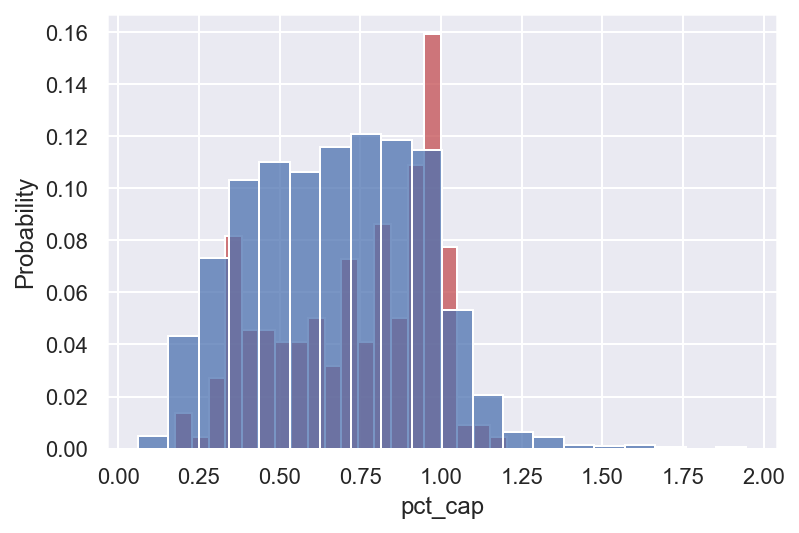

In [347]:
all_features_fs = all_features.merge(home_series2, left_on = ['team_game_x', 'team_ID_x'], right_on = ['team_game', 'team_ID'], how = 'left')
all_features_fs
all_features_fs['first_series'] = all_features_fs['team_game_y'].notna().astype(int)

sns.histplot(data = all_features_fs[all_features_fs['first_series'] == 1], x= 'pct_cap', stat = 'probability', color = 'r', bins = 20)
sns.histplot(data = all_features_fs[all_features_fs['first_series'] == 0], x= 'pct_cap', stat = 'probability', bins = 20);

In [348]:
mask2 = (all_features_fs['homeORvis'] == 1 )


all_features_fs = all_features_fs[mask2]


In [349]:
test = all_features_fs[key_feats]
test.iloc[:,1:]

,Weekend,max_temp,precip,night,opp_WL,avg_runs,avg_runs_allowed,streak,WL_pct,games_back,extra_innings,reschedule
7,0,73,0,0,0.222222,8.2,5.6,1.0,0.500000,2.0,0.0,0
8,1,59,0,1,0.200000,7.8,4.8,2.0,0.555556,2.0,0.0,0
9,1,77,0,0,0.272727,5.8,4.4,-1.0,0.500000,3.0,0.0,0
10,0,63,0,1,0.454545,5.2,4.2,1.0,0.545455,1.5,0.0,0
11,0,82,0,1,0.500000,5.4,4.4,-1.0,0.500000,1.5,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4720,0,75,0,1,0.509677,5.4,4.0,1.0,0.554839,9.0,0.0,0
4721,0,84,0,1,0.500000,6.2,3.4,4.0,0.563291,7.5,0.0,0
4722,0,77,0,0,0.496855,6.2,3.2,5.0,0.566038,7.0,0.0,0
4723,0,71,0,1,0.581250,5.8,2.8,6.0,0.568750,6.0,0.0,0


In [350]:
test.corr()

,pct_cap,Weekend,max_temp,precip,night,opp_WL,avg_runs,avg_runs_allowed,streak,WL_pct,games_back,extra_innings,reschedule
pct_cap,1.000000,0.238255,0.043995,-0.021347,-0.094308,0.022328,0.193786,-0.156326,0.147789,0.408058,-0.403140,0.007919,0.018784
Weekend,0.238255,1.000000,0.022064,-0.024775,-0.475172,-0.016463,0.016347,-0.021252,0.034890,0.018645,0.006157,0.008580,-0.029197
max_temp,0.043995,0.022064,1.000000,-0.068324,0.092566,0.025146,0.054862,0.029542,0.031588,0.017823,0.141229,-0.010545,-0.031987
precip,-0.021347,-0.024775,-0.068324,1.000000,-0.006369,-0.011874,-0.008636,-0.013726,-0.003244,0.000038,-0.065893,0.013674,0.042900
night,-0.094308,-0.475172,0.092566,-0.006369,1.000000,0.029084,0.010022,0.030161,-0.024022,-0.005297,0.026147,-0.005145,-0.057442
opp_WL,0.022328,-0.016463,0.025146,-0.011874,0.029084,1.000000,-0.136824,0.158418,-0.252796,-0.321843,0.079567,0.003575,0.060058
avg_runs,0.193786,0.016347,0.054862,-0.008636,0.010022,-0.136824,1.000000,0.005096,0.381756,0.325564,-0.210982,0.012116,-0.013731
avg_runs_allowed,-0.156326,-0.021252,0.029542,-0.013726,0.030161,0.158418,0.005096,1.000000,-0.421114,-0.339959,0.322993,-0.021072,0.026039
streak,0.147789,0.034890,0.031588,-0.003244,-0.024022,-0.252796,0.381756,-0.421114,1.000000,0.347168,-0.259452,-0.017376,-0.011026
WL_pct,0.408058,0.018645,0.017823,0.000038,-0.005297,-0.321843,0.325564,-0.339959,0.347168,1.000000,-0.638141,0.005545,-0.016233


In [351]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [352]:
def vif(df_X):
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [353]:
vif(X)

pct_cap             11.981030
Weekend              2.062926
max_temp            22.272125
precip               1.381350
night                3.786491
opp_WL              15.558356
avg_runs            13.346065
avg_runs_allowed    12.704329
streak               1.521029
WL_pct              24.424961
games_back           2.460670
dtype: float64

In [478]:
# We only analyze the VIF for predictors

key_feats2 = [ 'Weekend', 'precip',  'night', 
       'avg_runs', 'WL_pct', 'streak',
       'games_back']



vif(test[key_feats2])

Weekend        1.883405
precip         1.372794
night          3.606996
avg_runs      11.334247
WL_pct        12.635156
streak         1.175029
games_back     1.611460
dtype: float64

In [479]:
X = all_features_fs[key_feats]
y = all_features_fs['pct_cap']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=13)

In [480]:
X1 = X[key_feats2]
y2 = np.sqrt(y)
X2 = X1.copy()

# X2['gb_x_WL'] = X2['games_back'] * X2['WL_pct']
X2['night_x_weekend'] = X2['night'] * X2['Weekend']


In [481]:
lm = LinearRegression()
lm2 = LinearRegression()
lm3 = LinearRegression()
lm4 = LinearRegression()


In [482]:
lm.fit(X1, y)
lm2.fit(X2, y2)
lm3.fit(X2, y)
lm4.fit(X1, y2)

LinearRegression()

In [483]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
print('base y \t \t  \t--> ',mean(cross_val_score(lm, X1, y, cv=kf, scoring='neg_mean_absolute_error')),
      "\n",'Interaction (y) \t -->', mean(cross_val_score(lm3, X2, y, cv=kf, scoring='neg_mean_absolute_error')))

base y 	 	  	-->  -0.17152257243906077 
 Interaction (y) 	 --> -0.16995478291246618


In [464]:
mean(cross_val_score(lm3, X2, y, cv=kf, scoring='neg_mean_absolute_error'))

# sns.jointplot(x=preds,y=y2, kind = 'reg');
# plt.savefig("/Users/philliprichardson/Metis/Module 2/pred v resid",bbox_inches='tight')

-0.17013332854053667

In [465]:
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))

MAE(y,preds)

0.19758348708296722

In [466]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

RMSE(y2,preds)

0.13401584547042686

In [470]:
kf = key_feats2.copy()
kf.append('pct_cap')
test = all_features_fs[kf]

/Users/philliprichardson/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


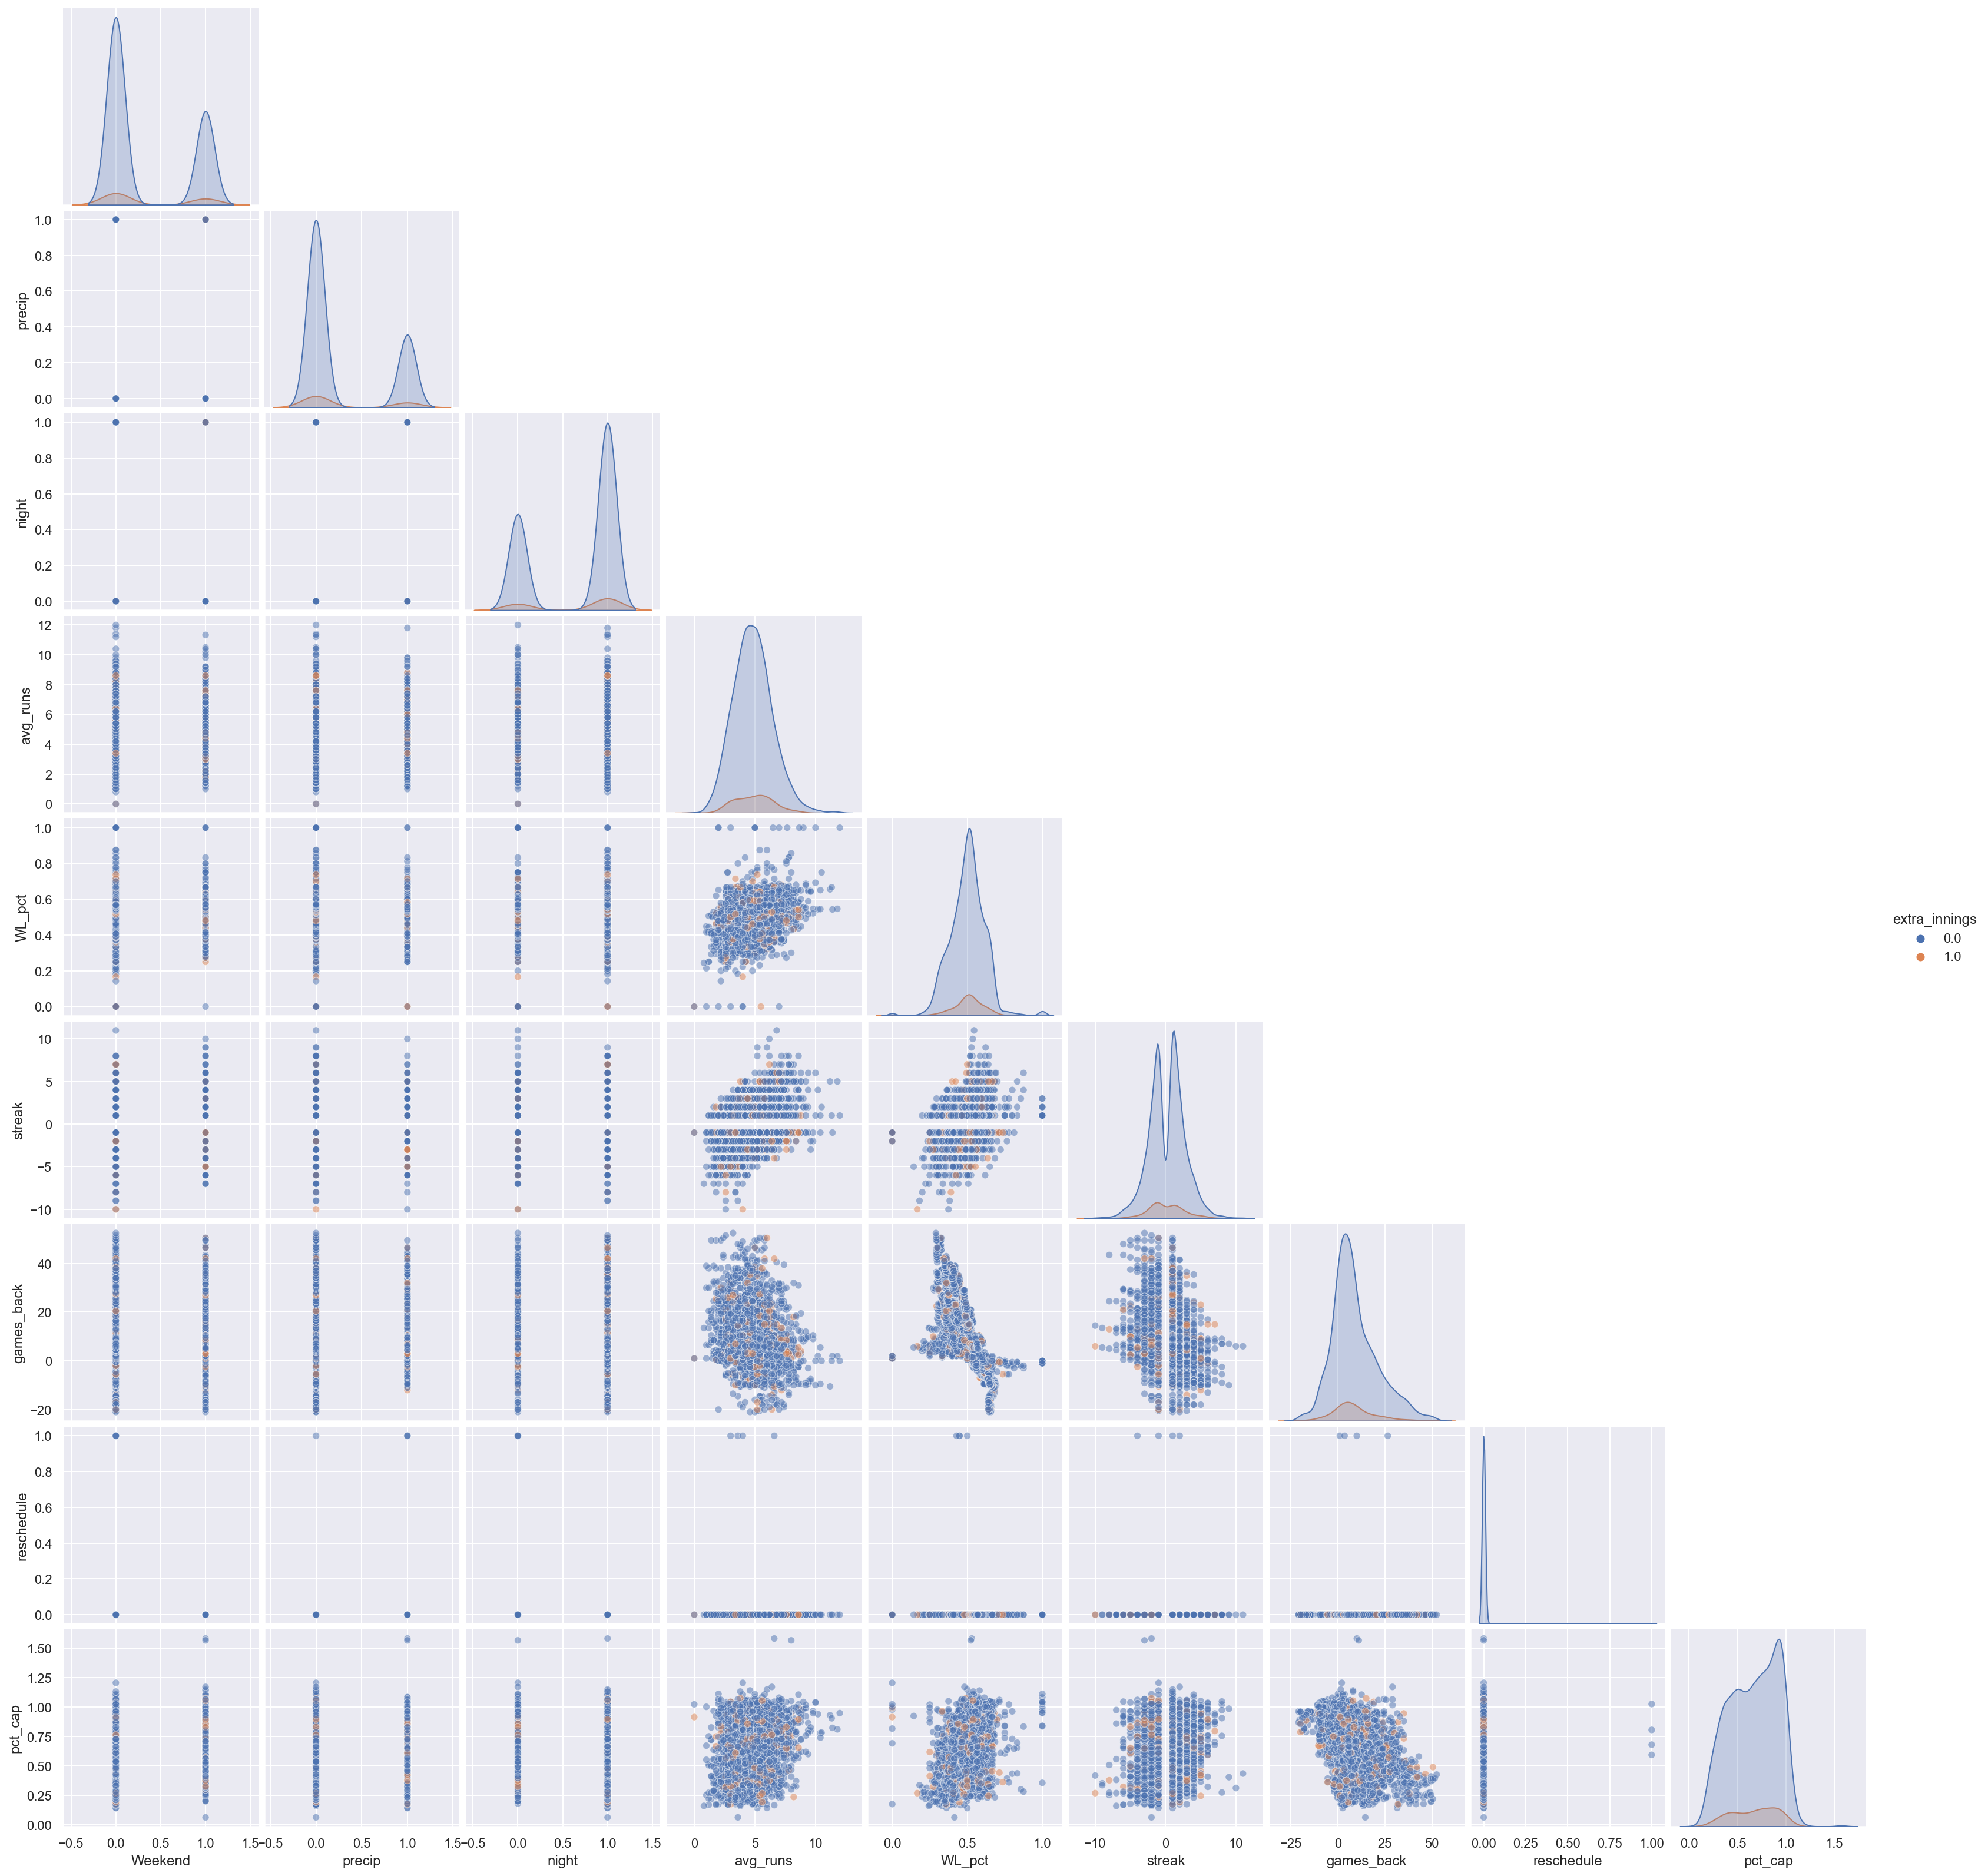

In [471]:
sns.pairplot(data = test, corner = True, hue = 'extra_innings', plot_kws = {'alpha': 0.5})

In [437]:
lm2.score(X_test[key_feats3], y_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 9)

In [34]:
lm2.score(X2, y)

lm2.

SyntaxError: invalid syntax (<ipython-input-34-0ab95c126231>, line 3)

In [298]:
#Create the model
model = sm.OLS(y, sm.add_constant(X2)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                pct_cap   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     71.31
Date:                Tue, 11 May 2021   Prob (F-statistic):          1.03e-123
Time:                        14:30:27   Log-Likelihood:                 309.96
No. Observations:                1889   AIC:                            -597.9
Df Residuals:                    1878   BIC:                            -536.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4304      0.039     10.943      0.000       0.353       0.508
Weekend              0.0520      0.017      3.058      0.002       0.019       0.085
precip              -0.0177      0.011     -1.669      0.095      -0.039       0.003
night               -0.0411      0.015     -2.716      0.007      -0.071      -0.011
avg_runs             0.0114      0.003      3.350      0.001       0.005       0.018
avg_runs_allowed     0.0001      0.004      0.035      0.972      -0.007       0.007
WL_pct               0.4595      0.057      7.992      0.000       0.347       0.572
games_back          -0.0115      0.002     -7.121      0.000      -0.015      -0.008
streak              -0.0052      0.002     -2.231      0.026      -0.010      -0.001
nigh_x_weekend2      0.0152      0.004      4.216      0.000       0.008       0.022
nigh_x_weekend       0.1256      0.023      5.494      0.000       0.081       0.170
==============================================================================
Omnibus:                       19.217   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.687
Skew:                          -0.171   Prob(JB):                     0.000238
Kurtosis:                       2.692   Cond. No.                         237.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""